In [50]:
# 5c22 Computational Method Assignment - Implementation of Bayesian Matting
# Author - Group : Yin Yang Artistic Chaos (Yuning, Abhishek, ChaiJie)

In [51]:
import numpy as np
from scipy.ndimage import gaussian_filter
import cv2
from numba import jit 
from PIL import Image 
import PIL 
import matplotlib.pyplot as plt

In [52]:
from orchard_bouman_clust import clustFunc

In [53]:
def matlab_style_gauss2d(shape=(3, 3), sigma=0.5):
    """
    2D gaussian mask - should give the same result as MATLAB's
    fspecial('gaussian',[shape],[sigma])
    """
    m, n = [(ss-1.)/2. for ss in shape]
    y, x = np.ogrid[-m:m+1, -n:n+1]
    h = np.exp(-(x*x + y*y)/(2.*sigma*sigma))
    h[h < np.finfo(h.dtype).eps*h.max()] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    return h

In [54]:
@jit(nopython=True, cache=True)
def get_window(m, x, y, N):
    h, w, c = m.shape
    halfN = N//2
    r = np.zeros((N, N, c))
    xmin = max(0, x - halfN); xmax = min(w, x + (halfN+1))
    ymin = max(0, y - halfN); ymax = min(h, y + (halfN+1))
    pxmin = halfN - (x-xmin); pxmax = halfN + (xmax-x)
    pymin = halfN - (y-ymin); pymax = halfN + (ymax-y)

    r[pymin:pymax, pxmin:pxmax] = m[ymin:ymax, xmin:xmax]
    return r

In [55]:
@jit(nopython=True, cache=True)
def solve(mu_F, Sigma_F, mu_B, Sigma_B, C, sigma_C, alpha_init, maxIter, minLike):
    '''
    Solves for F,B and alpha that maximize the sum of log
    likelihoods at the given pixel C.
    input:
    mu_F - means of foreground clusters (for RGB, of size 3x#Fclusters)
    Sigma_F - covariances of foreground clusters (for RGB, of size
    3x3x#Fclusters)
    mu_B,Sigma_B - same for background clusters
    C - observed pixel
    alpha_init - initial value for alpha
    maxIter - maximal number of iterations
    minLike - minimal change in likelihood between consecutive iterations

    returns:
    F,B,alpha - estimate of foreground, background and alpha
    channel (for RGB, each of size 3x1)
    '''
    I = np.eye(3)
    FMax = np.zeros(3)
    BMax = np.zeros(3)
    alphaMax = 0
    maxlike = - np.inf
    invsgma2 = 1/sigma_C**2
    for i in range(mu_F.shape[0]):
        mu_Fi = mu_F[i]
        invSigma_Fi = np.linalg.inv(Sigma_F[i])
        for j in range(mu_B.shape[0]):
            mu_Bj = mu_B[j]
            invSigma_Bj = np.linalg.inv(Sigma_B[j])

            alpha = alpha_init
            myiter = 1
            lastLike = -1.7977e+308
            while True:
                # solve for F,B
                A11 = invSigma_Fi + I*alpha**2 * invsgma2
                A12 = I*alpha*(1-alpha) * invsgma2
                A22 = invSigma_Bj+I*(1-alpha)**2 * invsgma2
                A = np.vstack((np.hstack((A11, A12)), np.hstack((A12, A22))))
                b1 = invSigma_Fi @ mu_Fi + C*(alpha) * invsgma2
                b2 = invSigma_Bj @ mu_Bj + C*(1-alpha) * invsgma2
                b = np.atleast_2d(np.concatenate((b1, b2))).T

                X = np.linalg.solve(A, b)
                F = np.maximum(0, np.minimum(1, X[0:3]))
                B = np.maximum(0, np.minimum(1, X[3:6]))
                # solve for alpha

                alpha = np.maximum(0, np.minimum(1, ((np.atleast_2d(C).T-B).T @ (F-B))/np.sum((F-B)**2)))[0,0]
                # # calculate likelihood
                L_C = - np.sum((np.atleast_2d(C).T -alpha*F-(1-alpha)*B)**2) * invsgma2
                L_F = (- ((F- np.atleast_2d(mu_Fi).T).T @ invSigma_Fi @ (F-np.atleast_2d(mu_Fi).T))/2)[0,0]
                L_B = (- ((B- np.atleast_2d(mu_Bj).T).T @ invSigma_Bj @ (B-np.atleast_2d(mu_Bj).T))/2)[0,0]
                like = (L_C + L_F + L_B)
                #like = 0

                if like > maxlike:
                    alphaMax = alpha
                    maxlike = like
                    FMax = F.ravel()
                    BMax = B.ravel()

                if myiter >= maxIter or abs(like-lastLike) <= minLike:
                    break

                lastLike = like
                myiter += 1
    return FMax, BMax, alphaMax

In [56]:
def bayesian_matte(img, trimap, sigma=8, N=125, minN=10, N_max = 175):
    '''
    '''
    # Step 1 :- Taking the input image converting it into double and initializing alpha with image sizes
    im = img/255 
    h, w, c = im.shape 
    alpha = np.zeros((h, w))

    # Step 2 :- creates seperate logical matrix of foreground, backgound and unknown region
    fg_reg = trimap == 255
    bg_reg = trimap == 0
    unkmask = True ^ np.logical_or(fg_reg, bg_reg)

    # Step 3 :- Creating three channels for foreground and Background matrix 
    foreground = im*np.repeat(fg_reg[:, :, np.newaxis], 3, axis=2)
    background = im*np.repeat(bg_reg[:, :, np.newaxis], 3, axis=2)

    #Step 4 :- Creating only FG areas = 1 & unknown region = NaN in trimap, and creating new matrix for Foreground, Backgorund and Alpha for seperate computations 
    alpha[fg_reg] = 1
    F = np.zeros(im.shape)
    B = np.zeros(im.shape)
    Al_pha = np.zeros(trimap.shape)
    alpha[unkmask] = np.nan
    
    # Step 5 : - Creating a sum of all the unknown pixels
    Unknown_sum = np.sum(unkmask)
    unkreg = unkmask
    
    # While Loop parameters and window counters
    n = 1
    m_i = 0
    max_li = 10
    # Kernel is matrix which is used to erode the borders of the the unknown region
    kernel = np.ones((3, 3))

    while n < Unknown_sum:
        # Step 5.1 :- certain pixels are removed from the unknown region of the image to detect the edges of the image.
        unkreg = cv2.erode(unkreg.astype(np.uint8), kernel, iterations=1)
        unkpixels = np.logical_and(np.logical_not(unkreg), unkmask)

        # Step 5.2 :- As per the bayesian matting paper, guassian falloff is used for weighting each pixel neighborhood range set earlier.
        # This creates a gaussian filter of size N x N, that can be applied to the image, given the image follows normal distribution. 
        gaussian_weights = matlab_style_gauss2d((N, N), sigma)
        gaussian_weights = gaussian_weights/np.max(gaussian_weights)

        # Step 5.3 finding the position of the pixels inside the above unknown boundary region.
        Y, X = np.nonzero(unkpixels)
        
        max_rep = 0
        
        # Step 5.4 :- Creating a for loop inside the unknown region for iterating along the count of Y that we just computed.
        for i in range(Y.shape[0]):
            # creating a progress bar based on the number of unknown pixels
            if n % 100 == 0:
                print(n, Unknown_sum)

            # taking the pixel and reshaping its 3 channel value into a 3 X 1 matrix
            y, x = Y[i], X[i]
            p = im[y, x]
            
            # Step 5.5 :- taking the surrounding pixel values around that pixel. (Used calcsurr_alpha Function to calaculate surrounding values
            a = get_window(alpha[:, :, np.newaxis], x, y, N)[:, :, 0]


            # Step 5.6 :- Taking the surrounding pixel values around that pixel in foreground region. (Used calcsurr_alpha Function to calaculate surrounding values). 
            # Then Calculating weights of that pixel = unknown pixel matrix squared X gausian matrix and then is structured as required.
            f_pixels = get_window(foreground, x, y, N)
            f_weights = (a**2 * gaussian_weights).ravel()

            f_pixels = np.reshape(f_pixels, (N*N, 3))
            posInds = np.nan_to_num(f_weights) > 0
            f_pixels = f_pixels[posInds, :]
            f_weights = f_weights[posInds]

            # Step 5.7 :- taking the surrounding pixel values around that pixel in background region. (Used calcsurr_alpha Function to calaculate surrounding values. 
            # Then Calculating weights of that pixel = (1 - unknown pixel matrix) squared X gausian matrix and then is structured as required.
            b_pixels = get_window(background, x, y, N)
            b_weights = ((1-a)**2 * gaussian_weights).ravel()

            b_pixels = np.reshape(b_pixels, (N*N, 3))
            posInds = np.nan_to_num(b_weights) > 0
            b_pixels = b_pixels[posInds, :]
            b_weights = b_weights[posInds]

             # Step 5.8 :- Clustering function will be done only weights of F & B are more than 10 or else we go to next iteration without clustering.
            if len(f_weights) < minN or len(b_weights) < minN:
                max_rep = max_rep + 1; 
            # Step 5.8.1* If whole iteration in the for loop runs without getting enough background or foreground values for some time, 
            # means the loop has become infinite as no more suitable window to calculate F,B and alpha, hence condition to check the same thing again increased window size 
            # and break the loop and display the result accordingly.
                if (max_rep == len(Y)):
                    m_i = m_i + 1
                    if (m_i == max_li):
                        m_i = 0
                        N = N + 10
                        if (N == N_max):
                            n = Unknown_sum
                continue


            # Step 5.9 :- Partitioning the foreground and background pixels (in a weighted manner with a clustering function) and calculate the mean and variance of the cluster.
            mu_f, sigma_f = clustFunc(f_pixels, f_weights)
            mu_b, sigma_b = clustFunc(b_pixels, b_weights)

            # Step 5.10 :- Calculates the initial alpha value mean of the surrounding pixels.
            alpha_init = np.nanmean(a.ravel())

            # Step 5.11 :- Calculating the F, B and alpha values based on MAP and Bayes method.
            f, b, alphaT = solve(mu_f, sigma_f, mu_b, sigma_b, p, 0.01, alpha_init, 50, 1e-6)

            # Step 5.12 :- Assigning the F, B and alpha values.
            foreground[y, x] = f.ravel()
            background[y, x] = b.ravel()
            alpha[y, x] = alphaT
            
            # Step 5.13 :- Removing from unkowns for the next iteration.
            unkmask[y, x] = 0
            
            n += 1

    return alpha

In [57]:
from QualityTest import mse2d
from compositing import compositing

100 55831
200 55831
300 55831
400 55831
500 55831
600 55831
700 55831
800 55831
900 55831
1000 55831
1100 55831
1200 55831
1300 55831
1400 55831
1500 55831
1600 55831
1700 55831
1800 55831
1900 55831
2000 55831
2100 55831
2200 55831
2300 55831
2400 55831
2500 55831
2600 55831
2700 55831
2800 55831
2900 55831
3000 55831
3100 55831
3200 55831
3300 55831
3400 55831
3500 55831
3600 55831
3700 55831
3800 55831
3900 55831
4000 55831
4100 55831
4200 55831
4300 55831
4400 55831
4500 55831
4600 55831
4700 55831
4800 55831
4900 55831
5000 55831
5100 55831
5200 55831
5300 55831
5400 55831
5500 55831
5600 55831
5700 55831
5800 55831
5900 55831
6000 55831
6100 55831
6200 55831
6300 55831
6400 55831
6500 55831
6600 55831
6700 55831
6800 55831
6900 55831
7000 55831
7100 55831
7200 55831
7300 55831
7400 55831
7500 55831
7600 55831
7700 55831
7800 55831
7900 55831
8000 55831
8100 55831
8200 55831
8300 55831
8400 55831
8500 55831
8600 55831
8700 55831
8800 55831
8900 55831
9000 55831
9100 55831
9200 558

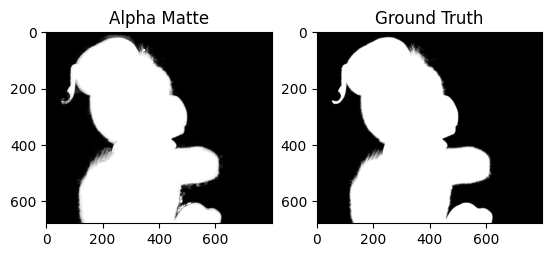

In [58]:

 #Step - Reading the input image, trimap and GT - alpha matte of that image.
img = cv2.imread("C:/Users/aduttagu/Desktop/Bayesian-Matting-Implementation/input_training_lowres/GT06.png")[:, :, :3]
trimap = cv2.imread("C:/Users/aduttagu/Desktop/Bayesian-Matting-Implementation/trimap_training_lowres/Trimap1/GT06.png")
GT = cv2.imread("C:/Users/aduttagu/Desktop/Bayesian-Matting-Implementation/gt_training_lowres/GT06.png")
trimap = trimap[:, :, 0]
GT = GT[:, :, 0]

#Step - Displaying the Alpha Matte and Ground Truth after calculating ALpha, Refer Function above for details
alpha = bayesian_matte(img, trimap)

fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(alpha, cmap='gray')
axes[0].set_title('Alpha Matte')
axes[1].imshow(GT, cmap='gray')
axes[1].set_title('Ground Truth')
plt.show()






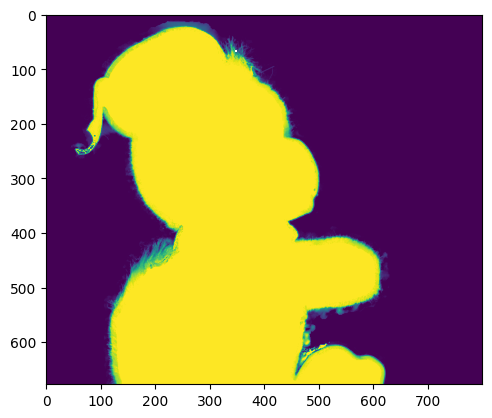

In [59]:
plt.imshow(alpha)
plt.show()

(678, 800, 3)
(678, 800)
(678, 800, 3)
(678, 800, 1)


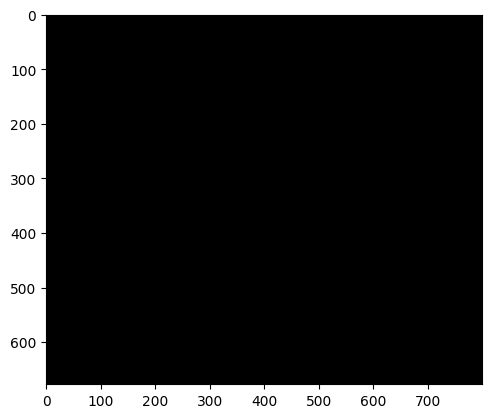

In [73]:
background = cv2.imread('C:/Users/aduttagu/Desktop/Bayesian-Matting-Implementation/background.png')
img = img / 255
alpha = alpha / 255
background = background / 255


resized_back = cv2.resize(background, None, fx=(img.shape[1]/background.shape[1]), fy=(img.shape[0]/background.shape[0]), interpolation=cv2.INTER_AREA)

print(img.shape)
print(alpha.shape)
print(resized_back.shape)

Sh1 = alpha.shape[0]
Sh2 = alpha.shape[1]

alpha1 = alpha.reshape((Sh1, Sh2, 1))
print(alpha1.shape)


comp1 = img * (alpha1) #+ resized_back * (1 - alpha2)
    



# alpha2 = np.repeat(alpha1, 3, axis=2)
# print(alpha2.shape)



# comp = img * (alpha2) + resized_back * (1 - alpha2)
# print(comp.shape)



plt.imshow(comp1)
plt.show()

